## Dataset Used  
[LFW (Labelled Faces in the Wild)](https://www.kaggle.com/learn)

In [4]:
from pathlib import Path
dataset_path = Path("./lfw")

matchpairs_train_csv = dataset_path / "matchpairsDevTrain.csv"
assert matchpairs_train_csv.exists(), f"Expected {matchpairs_train_csv} to exist."


mismatches_train_csv = dataset_path / "mismatchpairsDevTrain.csv"
assert mismatches_train_csv.exists(), f"Expected {mismatches_train_csv} to exist."

matchpairs_test_csv = dataset_path / "matchpairsDevTest.csv"
assert matchpairs_test_csv.exists(), f"Expected {matchpairs_test_csv} to exist."

mismatches_test_csv = dataset_path / "mismatchpairsDevTest.csv"
assert mismatches_test_csv.exists(), f"Expected {mismatches_test_csv} to exist."

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, classification_report
import random
from tqdm import tqdm

In [6]:
import tensorflow as tf

# Check GPU availability
print("GPU Available: ", tf.config.list_physical_devices("GPU"))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

# Check what device TensorFlow is using
if tf.config.list_physical_devices("GPU"):
    print("TensorFlow is using GPU")
    # Force GPU usage (optional)
    with tf.device("/GPU:0"):
        # Your model training code here
        pass
else:
    print("TensorFlow is using CPU")

GPU Available:  []
Built with CUDA:  False
TensorFlow is using CPU


In [7]:
# Configuration
IMG_SIZE = (224, 224)
RESIZED_IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def get_image_path(person_name, image_num):
    """Get the path to an image given person name and image number"""
    img_name = f"{person_name}_{image_num:04d}.jpg"
    return dataset_path / "lfw-deepfunneled" / "lfw-deepfunneled" / person_name / img_name

def load_and_preprocess_image(image_path):
    """Load and preprocess an image"""
    try:
        # Load image
        img = load_img(image_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        # Normalize to [0,1]
        img_array = img_array / 255.0
        # Resize to RESIZED_IMG_SIZE
        img_array = tf.image.resize(img_array, RESIZED_IMG_SIZE)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        # Return a black image if loading fails
        return np.zeros((*IMG_SIZE, 3))

def load_pairs_data(csv_file, is_match=True):
    """Load pairs data from CSV file"""
    df = pd.read_csv(csv_file)
    pairs = []
    labels = []
    
    for _, row in df.iterrows():
        if is_match:
            # Match pairs: same person, different images
            name = row['name']
            img1_path = get_image_path(name, row['imagenum1'])
            img2_path = get_image_path(name, row['imagenum2'])
            label = 1  # Same person
        else:
            # Mismatch pairs: different persons
            name1 = row.iloc[0]  # First name column
            name2 = row.iloc[2]  # Second name column  
            img1_path = get_image_path(name1, row.iloc[1])  # First image num
            img2_path = get_image_path(name2, row.iloc[3])  # Second image num
            label = 0  # Different persons
        
        pairs.append((img1_path, img2_path))
        labels.append(label)
    
    return pairs, labels

In [8]:
# Load training data
print("Loading training data...")
match_pairs_train, match_labels_train = load_pairs_data(matchpairs_train_csv, is_match=True)
mismatch_pairs_train, mismatch_labels_train = load_pairs_data(mismatches_train_csv, is_match=False)

# Combine training data
train_pairs = match_pairs_train + mismatch_pairs_train
train_labels = match_labels_train + mismatch_labels_train

print(f"Training data: {len(train_pairs)} pairs")
print(f"Positive pairs (same person): {sum(train_labels)}")
print(f"Negative pairs (different person): {len(train_labels) - sum(train_labels)}")

# Load test data
print("\nLoading test data...")
match_pairs_test, match_labels_test = load_pairs_data(matchpairs_test_csv, is_match=True)
mismatch_pairs_test, mismatch_labels_test = load_pairs_data(mismatches_test_csv, is_match=False)

# Combine test data
test_pairs = match_pairs_test + mismatch_pairs_test
test_labels = match_labels_test + mismatch_labels_test

print(f"Test data: {len(test_pairs)} pairs")
print(f"Positive pairs (same person): {sum(test_labels)}")
print(f"Negative pairs (different person): {len(test_labels) - sum(test_labels)}")

Loading training data...
Training data: 2200 pairs
Positive pairs (same person): 1100
Negative pairs (different person): 1100

Loading test data...
Test data: 1000 pairs
Positive pairs (same person): 500
Negative pairs (different person): 500


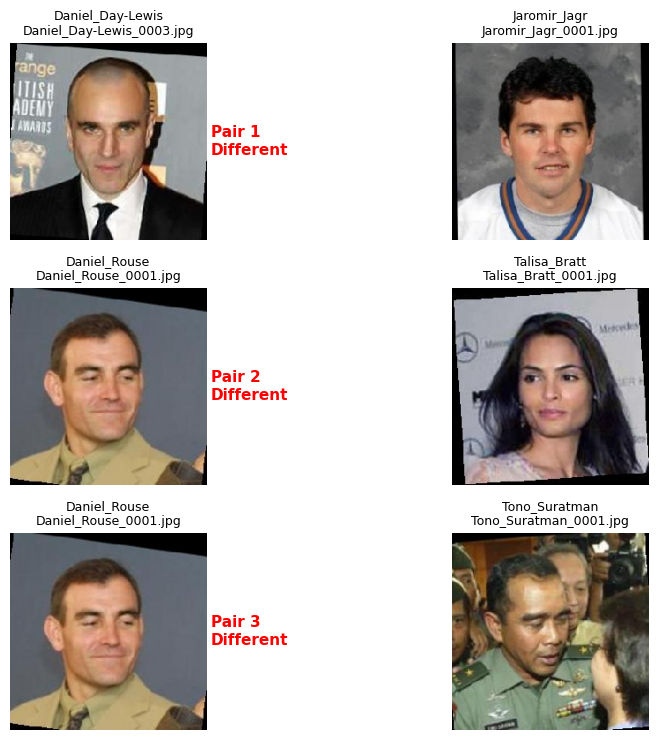

In [9]:
import numpy as np

# visualize some pairs (improved: show names, filenames and colored borders for easy distinction)

def visualize_pairs(pairs, labels, num_pairs=5):
    """Visualize pairs of images with readable info and colored border:
       green = same person, red = different persons"""
    num_pairs = min(num_pairs, len(pairs))
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs * 2.5))
    if num_pairs == 1:
        axes = axes.reshape(1, 2)
    
    for i in range(num_pairs):
        img1_path, img2_path = pairs[i]
        true_label = int(labels[i])
        label_str = "Same" if true_label == 1 else "Different"
        color = "green" if true_label == 1 else "red"
        
        img1 = np.array(load_and_preprocess_image(img1_path))
        img2 = np.array(load_and_preprocess_image(img2_path))
        
        ax1, ax2 = axes[i, 0], axes[i, 1]
        ax1.imshow(np.clip(img1, 0, 1))
        ax1.axis("off")
        ax1.set_title(f"{img1_path.parent.name}\n{img1_path.name}", fontsize=9)
        
        ax2.imshow(np.clip(img2, 0, 1))
        ax2.axis("off")
        ax2.set_title(f"{img2_path.parent.name}\n{img2_path.name}", fontsize=9)
        
        # make spines visible and colored so the pair is distinguishable at a glance
        for ax in (ax1, ax2):
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(3)
        
        # add pair label between the two images
        ax1.text(1.02, 0.5, f"Pair {i+1}\n{label_str}", transform=ax1.transAxes,
                 va="center", fontsize=11, color=color, weight="bold")
    
    plt.tight_layout()
    plt.show()

# Example call (keep same slice as before)
random_index = random.randint(0, len(train_pairs) - 4)
visualize_pairs(train_pairs[random_index:], train_labels[random_index:], num_pairs=3)

In [10]:
import random
import tensorflow as tf


def create_tf_dataset(
    pairs,
    labels,
    batch_size=32,
    shuffle=True,
    buffer_size=None,  # if None, will default to len(pairs) when shuffling
):
    """
    Create a tf.data.Dataset of ((img1, img2), label) where:
      - img1/img2: float32 tensors of shape (H, W, 3)
      - label: float32 tensor of shape (1,)
    """


    def generator():
        indices = list(range(len(pairs)))
        if shuffle:
            random.shuffle(indices)

        for i in indices:
            img1_path, img2_path = pairs[i]
            y = labels[i]

            # Must return float32 of shape (H, W, 3)
            img1 = load_and_preprocess_image(
                img1_path
            )  # ensure it outputs (H,W,3) float32
            img2 = load_and_preprocess_image(img2_path)

            # Ensure label is float32 and shape (1,)
            y = tf.cast(y, tf.float32)
            y = tf.reshape(y, (1,))  # or keep scalar if your loss expects that

            yield (img1, img2), y

    output_signature = (
        (
            tf.TensorSpec(shape=(*RESIZED_IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(*RESIZED_IMG_SIZE, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(1,), dtype=tf.float32),
    )

    dataset = tf.data.Dataset.from_generator(
        generator, output_signature=output_signature
    )

    if shuffle:
        if buffer_size is None:
            buffer_size = len(pairs)
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        )

    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# Example usage:
# If your model resizes 256->96 internally, set img_size=(256,256)
train_dataset = create_tf_dataset(train_pairs, train_labels, batch_size=BATCH_SIZE, shuffle=True)
test_dataset  = create_tf_dataset(test_pairs,  test_labels,  batch_size=BATCH_SIZE, shuffle=False)

2025-09-08 13:33:22.120585: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


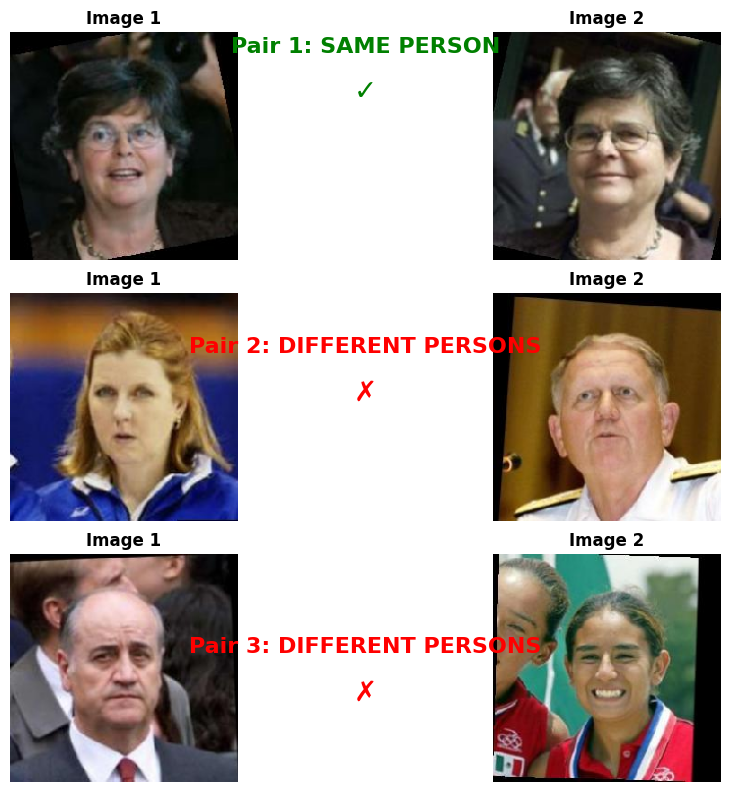

In [11]:
def visualize_tf_pairs(dataset, num_pairs=5):
    """Visualize pairs from a TensorFlow dataset with clear same/different labels.
    Note: tf.data.Dataset has unknown length, and `dataset` may be batched.
    We unbatch and take up to num_pairs samples to avoid using len(dataset)."""
    # Collect up to num_pairs samples from the (possibly batched) dataset
    samples = []
    for pair, label in dataset.unbatch().take(num_pairs):
        samples.append((pair, label))
    if len(samples) == 0:
        print("No samples available in the dataset to visualize.")
        return

    n = len(samples)
    fig, axes = plt.subplots(n, 2, figsize=(12, n * 3))
    if n == 1:
        axes = axes.reshape(1, 2)

    for i, (pair, label) in enumerate(samples):
        img1, img2 = pair
        true_label = int(label.numpy().reshape(-1)[0])
        label_str = "SAME PERSON" if true_label == 1 else "DIFFERENT PERSONS"
        color = "green" if true_label == 1 else "red"

        ax1, ax2 = axes[i, 0], axes[i, 1]

        # Display images
        ax1.imshow(np.clip(img1.numpy(), 0, 1))
        ax1.axis("off")
        ax1.set_title(f"Image 1", fontsize=12, fontweight="bold")

        ax2.imshow(np.clip(img2.numpy(), 0, 1))
        ax2.axis("off")
        ax2.set_title(f"Image 2", fontsize=12, fontweight="bold")

        # Add colored borders around images
        for ax in (ax1, ax2):
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(4)

        # Add large, prominent text between the images showing the relationship
        fig.text(
            0.5,
            1 - (i + 0.5) / n,
            f"Pair {i+1}: {label_str}",
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            color=color,
            transform=fig.transFigure,
        )

        # Add small arrow or symbol to make it even clearer
        symbol = "✓" if true_label == 1 else "✗"
        fig.text(
            0.5,
            1 - (i + 0.65) / n,
            symbol,
            ha="center",
            va="center",
            fontsize=20,
            color=color,
            transform=fig.transFigure,
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for the text
    plt.show()


# Example call to visualize pairs from the TensorFlow dataset
visualize_tf_pairs(train_dataset, num_pairs=3)

### Model building

In [12]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    Contrastive loss function for Siamese networks.

    Args:
        y_true: True labels (1 for same person, 0 for different persons)
        y_pred: Predicted distances
        margin: Margin for negative pairs
    """
    y_true = tf.cast(y_true, tf.float32)

    # For positive pairs (same person): minimize distance
    positive_loss = y_true * tf.square(y_pred)

    # For negative pairs (different persons): maximize distance up to margin
    negative_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))

    return tf.reduce_mean(positive_loss + negative_loss)


def accuracy_metric(y_true, y_pred, threshold=0.5):
    """
    Custom accuracy metric for Siamese networks.
    Predictions below threshold are considered same person.
    """
    y_true = tf.cast(y_true, tf.float32)
    predictions = tf.cast(y_pred < threshold, tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, predictions), tf.float32))

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os

# Create directories for saving models
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1
    ),
    ModelCheckpoint(
        filepath="models/best_siamese_model.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
]

print("Model compiled and ready for training!")
print(f"Training samples: {len(train_pairs)}")
print(f"Test samples: {len(test_pairs)}")

Model compiled and ready for training!
Training samples: 2200
Test samples: 1000


In [14]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history.history["accuracy_metric"], label="Training Accuracy")
    ax2.plot(history.history["val_accuracy_metric"], label="Validation Accuracy")
    ax2.set_title("Model Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [15]:
def evaluate_model(model, test_dataset, threshold=0.5):
    """Evaluate the model on test data"""
    predictions = model.predict(test_dataset)

    # Get true labels
    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    predicted_labels = (predictions.flatten() < threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=["Different", "Same"]
    )

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    return predictions, true_labels, predicted_labels

In [16]:
def preprocess_single_image(image_path):
    """Preprocess a single image for prediction"""
    img = load_and_preprocess_image(image_path)
    return np.expand_dims(img, axis=0)


def compare_faces(model, img1_path, img2_path, threshold=0.5):
    """
    Compare two face images and return similarity score
    """
    # Preprocess images
    img1 = preprocess_single_image(img1_path)
    img2 = preprocess_single_image(img2_path)

    # Predict distance
    distance = model.predict([img1, img2])[0][0]

    # Determine if same person
    is_same_person = distance < threshold
    confidence = 1 - distance if is_same_person else distance

    return {
        "distance": distance,
        "is_same_person": is_same_person,
        "confidence": confidence,
        "threshold": threshold,
    }


def visualize_prediction(img1_path, img2_path, result):
    """Visualize prediction result"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Load and display images
    img1 = np.array(load_and_preprocess_image(img1_path))
    img2 = np.array(load_and_preprocess_image(img2_path))

    ax1.imshow(np.clip(img1, 0, 1))
    ax1.set_title("Image 1", fontsize=14, fontweight="bold")
    ax1.axis("off")

    ax2.imshow(np.clip(img2, 0, 1))
    ax2.set_title("Image 2", fontsize=14, fontweight="bold")
    ax2.axis("off")

    # Add result text
    color = "green" if result["is_same_person"] else "red"
    result_text = "SAME PERSON" if result["is_same_person"] else "DIFFERENT PERSONS"

    plt.suptitle(
        f"{result_text}\nDistance: {result['distance']:.3f}, Confidence: {result['confidence']:.3f}",
        fontsize=16,
        fontweight="bold",
        color=color,
    )

    # Add colored borders
    for ax in (ax1, ax2):
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

In [17]:
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Lambda,
    BatchNormalization,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


def create_pretrained_base_network(
    input_shape, backbone="resnet50", trainable_layers=10
):
    """
    Create base network using pre-trained backbone

    Args:
        input_shape: Input image shape
        backbone: 'resnet50', 'vgg16', or 'efficientnet'
        trainable_layers: Number of top layers to make trainable
    """
    input_layer = Input(shape=input_shape)

    # Choose backbone
    if backbone == "resnet50":
        base_model = ResNet50(
            weights="imagenet", include_top=False, input_tensor=input_layer
        )
    elif backbone == "vgg16":
        base_model = VGG16(
            weights="imagenet", include_top=False, input_tensor=input_layer
        )
    elif backbone == "efficientnet":
        base_model = EfficientNetB0(
            weights="imagenet", include_top=False, input_tensor=input_layer
        )
    else:
        raise ValueError("Backbone must be 'resnet50', 'vgg16', or 'efficientnet'")

    # Freeze early layers, make top layers trainable
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Feature embedding layers
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Final embedding layer
    x = Dense(128, activation="relu", name="embedding")(x)  # 128-dim embedding

    return Model(input_layer, x, name=f"{backbone}_base_network")

In [18]:
def cosine_similarity(vectors):
    """Compute cosine similarity between two vectors"""
    x, y = vectors

    # Normalize vectors
    x_norm = K.l2_normalize(x, axis=1)
    y_norm = K.l2_normalize(y, axis=1)

    # Compute cosine similarity
    similarity = K.sum(x_norm * y_norm, axis=1, keepdims=True)

    # Convert to distance (1 - similarity)
    return 1 - similarity


def create_cosine_siamese_network(input_shape, backbone="resnet50"):
    """
    Create Siamese network with cosine similarity
    """
    base_network = create_pretrained_base_network(input_shape, backbone)

    input_a = Input(shape=input_shape, name="left_input")
    input_b = Input(shape=input_shape, name="right_input")

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Use cosine similarity instead of Euclidean distance
    distance = Lambda(
        cosine_similarity,
        output_shape=lambda shapes: (shapes[0][0], 1),
        name="cosine_distance",
    )([processed_a, processed_b])

    model = Model([input_a, input_b], distance, name="cosine_siamese_network")

    return model, base_network

input_shape = (*RESIZED_IMG_SIZE, 3)


# Alternative: Cosine-based Siamese network
cosine_siamese_model, _ = create_cosine_siamese_network(input_shape, backbone="resnet50")

In [19]:
cosine_siamese_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=contrastive_loss,
    metrics=[accuracy_metric]
)

In [20]:
# Training parameters
EPOCHS = 50

print("Starting training...")

# Train the model
history = cosine_siamese_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1,
)

print("Training completed!")

Starting training...
Epoch 1/50
     69/Unknown 223s 3s/step - accuracy_metric: 0.5315 - loss: 0.2726

2025-09-08 13:37:08.162738: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from None to 0.46254, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy_metric: 0.5070 - loss: 0.2734 - val_accuracy_metric: 0.4735 - val_loss: 0.4625 - learning_rate: 1.0000e-04
Epoch 2/50


2025-09-08 13:38:40.988705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2095 of 2200
2025-09-08 13:38:41.472876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.5378 - loss: 0.2563

2025-09-08 13:42:12.075766: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 0.46254 to 0.38629, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy_metric: 0.5472 - loss: 0.2528 - val_accuracy_metric: 0.4811 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.5782 - loss: 0.2528
Epoch 3: val_loss improved from 0.38629 to 0.27325, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy_metric: 0.5914 - loss: 0.2420 - val_accuracy_metric: 0.5369 - val_loss: 0.2733 - learning_rate: 1.0000e-04
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.6084 - loss: 0.2354

2025-09-08 13:52:21.719251: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 0.27325 to 0.25355, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy_metric: 0.6045 - loss: 0.2336 - val_accuracy_metric: 0.5833 - val_loss: 0.2536 - learning_rate: 1.0000e-04
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.6222 - loss: 0.2365
Epoch 5: val_loss improved from 0.25355 to 0.24251, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy_metric: 0.6195 - loss: 0.2313 - val_accuracy_metric: 0.5985 - val_loss: 0.2425 - learning_rate: 1.0000e-04
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.6435 - loss: 0.2249
Epoch 6: val_loss did not improve from 0.24251
69/69 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy_metric: 0.6266 - loss: 0.2264 - val_accuracy_metric: 0.5634 - val_loss: 0.2641 - learning_rate: 1.0000e-04
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.6580 - loss: 0.2161
Epoch 7:

2025-09-08 14:11:17.616704: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_loss improved from 0.24251 to 0.23790, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - accuracy_metric: 0.6643 - loss: 0.2070 - val_accuracy_metric: 0.5928 - val_loss: 0.2379 - learning_rate: 1.0000e-04
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.6947 - loss: 0.1983
Epoch 9: val_loss improved from 0.23790 to 0.22769, saving model to models/best_siamese_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy_metric: 0.6754 - loss: 0.2029 - val_accuracy_metric: 0.6231 - val_loss: 0.2277 - learning_rate: 1.0000e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.7072 - loss: 0.1945
Epoch 10: val_loss did not improve from 0.22769
69/69 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy_metric: 0.6909 - loss: 0.1981 - val_accuracy_metric: 0.6013 - val_loss: 0.2324 - learning_rate: 1.0000e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.7301 - loss: 0.1899
Epoch

2025-09-08 14:49:25.483924: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_loss did not improve from 0.22769
69/69 ━━━━━━━━━━━━━━━━━━━━ 282s 4s/step - accuracy_metric: 0.7920 - loss: 0.1520 - val_accuracy_metric: 0.5701 - val_loss: 0.2707 - learning_rate: 5.0000e-05
Epoch 17/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.8189 - loss: 0.1449
Epoch 17: val_loss did not improve from 0.22769
69/69 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy_metric: 0.8037 - loss: 0.1461 - val_accuracy_metric: 0.6174 - val_loss: 0.2397 - learning_rate: 5.0000e-05
Epoch 18/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.8317 - loss: 0.1364
Epoch 18: val_loss did not improve from 0.22769
69/69 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy_metric: 0.8165 - loss: 0.1387 - val_accuracy_metric: 0.5966 - val_loss: 0.2468 - learning_rate: 5.0000e-05
Epoch 19/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy_metric: 0.8455 - loss: 0.1342
Epoch 19: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 19: val_loss did not imp

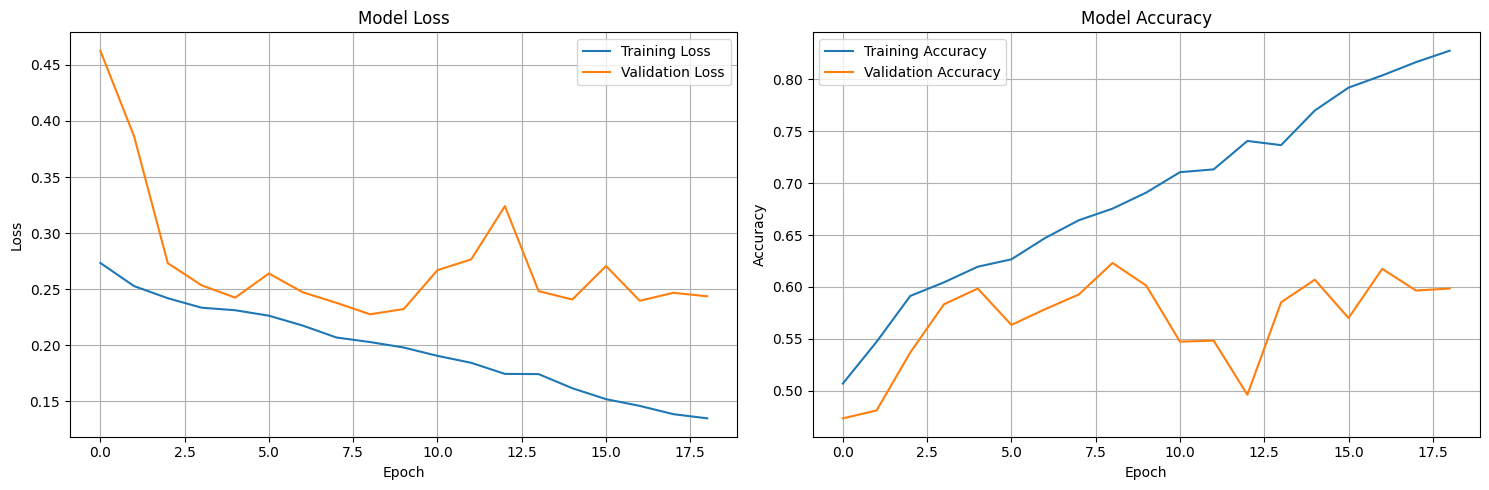

In [21]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history.history["accuracy_metric"], label="Training Accuracy")
    ax2.plot(history.history["val_accuracy_metric"], label="Validation Accuracy")
    ax2.set_title("Model Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history)

In [22]:
def evaluate_model(model, test_dataset, threshold=0.5):
    """Evaluate the model on test data"""
    predictions = model.predict(test_dataset)

    # Get true labels
    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    predicted_labels = (predictions.flatten() < threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=["Different", "Same"]
    )

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    return predictions, true_labels, predicted_labels


# Evaluate the model
test_predictions, test_true, test_pred = evaluate_model(
    cosine_siamese_model, test_dataset
)

32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step
Test Accuracy: 0.6400

Classification Report:
              precision    recall  f1-score   support

   Different       0.66      0.58      0.62       500
        Same       0.63      0.70      0.66       500

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.64      1000
weighted avg       0.64      0.64      0.64      1000



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


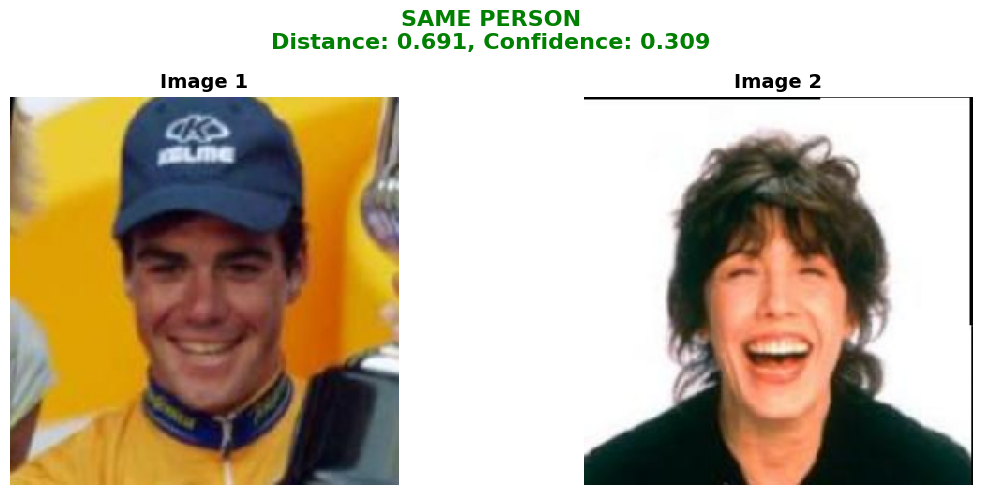

Ground truth: DIFFERENT PERSONS


In [23]:
# get random pair from test set
random_index = random.randint(0, len(test_pairs) - 1)
example_pair = test_pairs[random_index]
are_they_same = test_labels[random_index]
img1_path, img2_path = example_pair
# Compare the two images
result = compare_faces(cosine_siamese_model, img1_path, img2_path, threshold=0.7)
# Visualize the prediction
visualize_prediction(img1_path, img2_path, result)
print(f"Ground truth: {'SAME PERSON' if are_they_same==1 else 'DIFFERENT PERSONS'}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


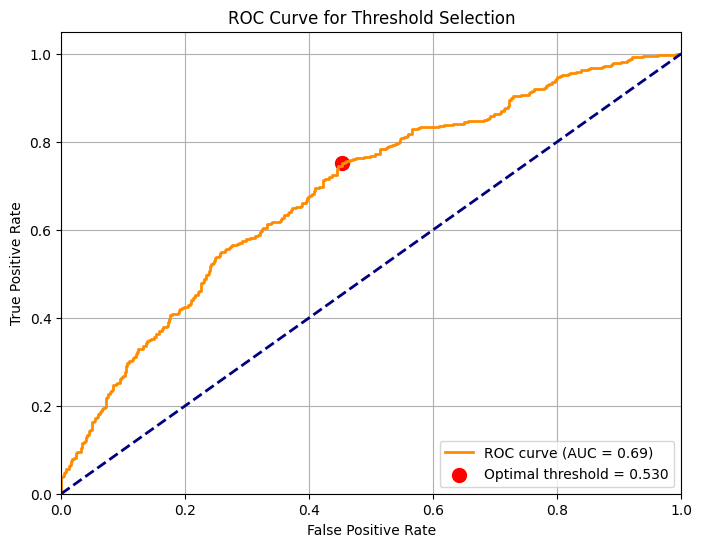

Optimal threshold: 0.530
AUC Score: 0.689


In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def find_optimal_threshold_roc(model, test_dataset):
    """Find optimal threshold using ROC curve analysis"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    # For ROC curve, we need to invert distances since lower distance = same person
    # Convert distances to similarity scores
    similarities = 1 - distances

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    roc_auc = auc(fpr, tpr)

    # Find optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_similarity = thresholds[optimal_idx]
    optimal_threshold_distance = 1 - optimal_threshold_similarity

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.scatter(
        fpr[optimal_idx],
        tpr[optimal_idx],
        color="red",
        s=100,
        label=f"Optimal threshold = {optimal_threshold_distance:.3f}",
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Threshold Selection")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return optimal_threshold_distance, roc_auc


# Find optimal threshold
optimal_threshold, auc_score = find_optimal_threshold_roc(
    cosine_siamese_model, test_dataset
)
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"AUC Score: {auc_score:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


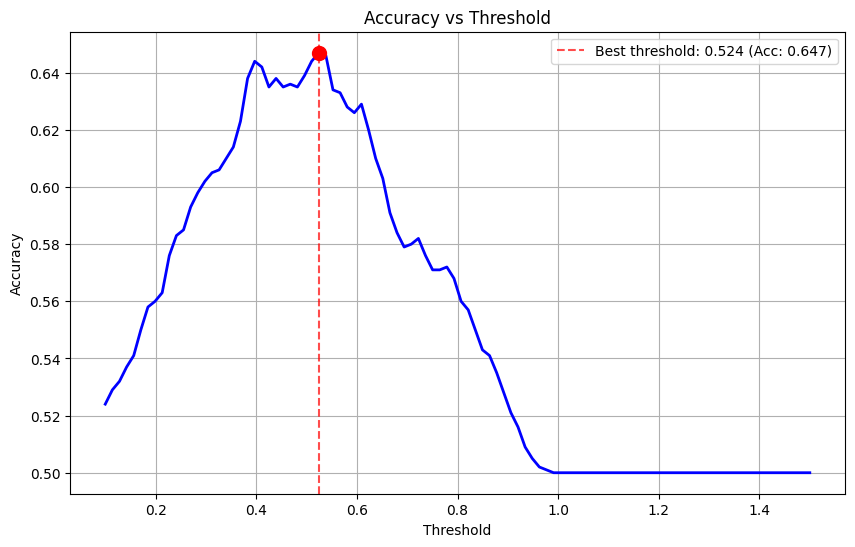

Best threshold: 0.524
Best accuracy: 0.647


In [25]:
def find_threshold_by_accuracy(model, test_dataset, threshold_range=(0.1, 1.5, 100)):
    """Find threshold that maximizes accuracy"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    # Test different thresholds
    thresholds = np.linspace(threshold_range[0], threshold_range[1], threshold_range[2])
    accuracies = []

    for threshold in thresholds:
        predicted_labels = (distances < threshold).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels)
        accuracies.append(accuracy)

    # Find best threshold
    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]

    # Plot accuracy vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, "b-", linewidth=2)
    plt.scatter(best_threshold, best_accuracy, color="red", s=100, zorder=5)
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Threshold")
    plt.grid(True)
    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Best threshold: {best_threshold:.3f} (Acc: {best_accuracy:.3f})",
    )
    plt.legend()
    plt.show()

    return best_threshold, best_accuracy


# Find threshold by accuracy
best_threshold, best_acc = find_threshold_by_accuracy(
    cosine_siamese_model, test_dataset
)
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best accuracy: {best_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


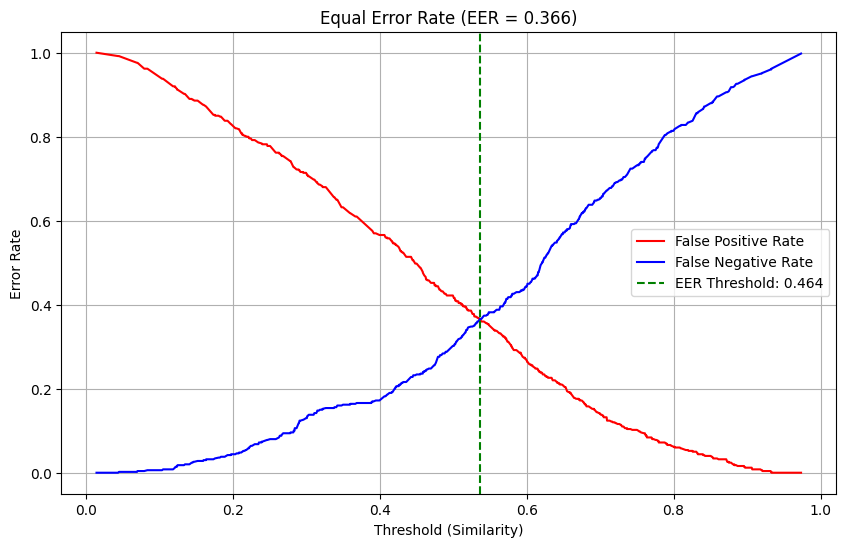

EER threshold: 0.464
EER rate: 0.366


In [26]:
def find_eer_threshold(model, test_dataset):
    """Find threshold at Equal Error Rate (EER)"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    # Calculate EER
    similarities = 1 - distances  # Convert to similarities
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    fnr = 1 - tpr  # False Negative Rate

    # Find where FPR ≈ FNR (Equal Error Rate)
    eer_idx = np.argmin(np.abs(fpr - fnr))
    eer_threshold_similarity = thresholds[eer_idx]
    eer_threshold_distance = 1 - eer_threshold_similarity
    eer_rate = (fpr[eer_idx] + fnr[eer_idx]) / 2

    # Plot EER
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fpr, label="False Positive Rate", color="red")
    plt.plot(thresholds, fnr, label="False Negative Rate", color="blue")
    plt.axvline(
        x=eer_threshold_similarity,
        color="green",
        linestyle="--",
        label=f"EER Threshold: {eer_threshold_distance:.3f}",
    )
    plt.xlabel("Threshold (Similarity)")
    plt.ylabel("Error Rate")
    plt.title(f"Equal Error Rate (EER = {eer_rate:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return eer_threshold_distance, eer_rate


# Find EER threshold
eer_threshold, eer_rate = find_eer_threshold(cosine_siamese_model, test_dataset)
print(f"EER threshold: {eer_threshold:.3f}")
print(f"EER rate: {eer_rate:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Shapes: precision=(1001,), recall=(1001,), thresholds=(1000,)
Found valid threshold at index 979
Achieved precision: 0.952, recall: 0.040


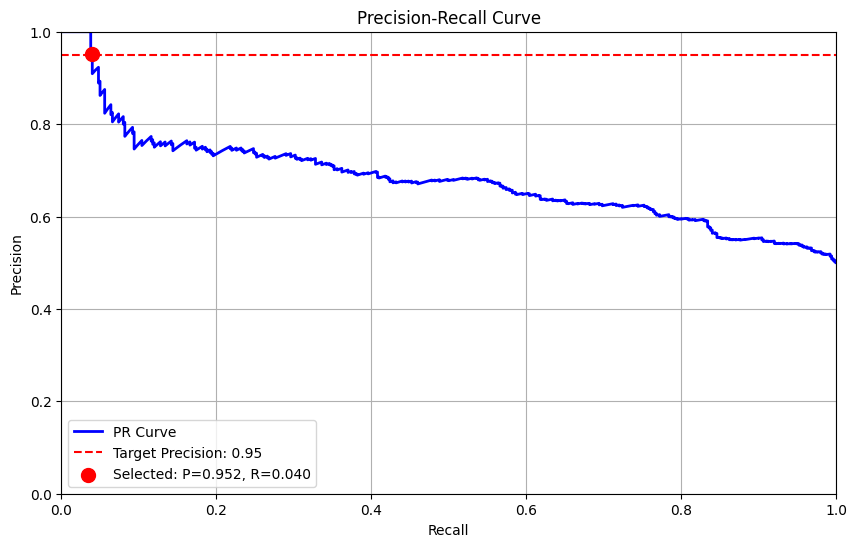

Threshold for 95% precision: 0.067


In [27]:
from sklearn.metrics import precision_recall_curve


def find_threshold_precision_recall_robust(model, test_dataset, target_precision=0.95):
    """Find threshold for target precision - robust version"""
    # Get predictions and true labels
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()
    similarities = 1 - distances

    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, similarities)

    print(
        f"Shapes: precision={precision.shape}, recall={recall.shape}, thresholds={thresholds.shape}"
    )

    # Handle the size mismatch (precision/recall have one more element than thresholds)
    if len(precision) == len(thresholds) + 1:
        precision = precision[:-1]
        recall = recall[:-1]

    # Find threshold for target precision
    target_idx = np.where(precision >= target_precision)[0]

    if len(target_idx) > 0:
        # Among points meeting precision requirement, pick the one with highest recall
        best_local_idx = np.argmax(recall[target_idx])
        best_idx = target_idx[best_local_idx]

        if best_idx < len(thresholds):  # Safety check
            target_threshold_similarity = thresholds[best_idx]
            target_threshold_distance = 1 - target_threshold_similarity
            achieved_precision = precision[best_idx]
            achieved_recall = recall[best_idx]

            print(f"Found valid threshold at index {best_idx}")
            print(
                f"Achieved precision: {achieved_precision:.3f}, recall: {achieved_recall:.3f}"
            )
        else:
            print(
                f"Index {best_idx} out of bounds for thresholds array of size {len(thresholds)}"
            )
            target_threshold_distance = 0.5
            achieved_precision = target_precision
            achieved_recall = 0.0
    else:
        print(f"Warning: Could not achieve {target_precision:.2f} precision.")
        print(f"Maximum achieved precision: {precision.max():.3f}")
        target_threshold_distance = 0.1  # Very conservative threshold
        achieved_precision = precision.max()
        achieved_recall = recall[np.argmax(precision)]

    # Plot PR curve
    precision_orig, recall_orig, _ = precision_recall_curve(true_labels, similarities)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_orig, precision_orig, "b-", linewidth=2, label="PR Curve")
    plt.axhline(
        y=target_precision,
        color="red",
        linestyle="--",
        label=f"Target Precision: {target_precision}",
    )

    # Mark the selected point
    if len(target_idx) > 0 and best_idx < len(thresholds):
        plt.scatter(
            achieved_recall,
            achieved_precision,
            color="red",
            s=100,
            zorder=5,
            label=f"Selected: P={achieved_precision:.3f}, R={achieved_recall:.3f}",
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

    return target_threshold_distance


# Use the robust version
pr_threshold = find_threshold_precision_recall_robust(
    cosine_siamese_model, test_dataset, target_precision=0.95
)
print(f"Threshold for 95% precision: {pr_threshold:.3f}")

=== COMPREHENSIVE THRESHOLD ANALYSIS ===

1. ROC Curve Analysis:
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


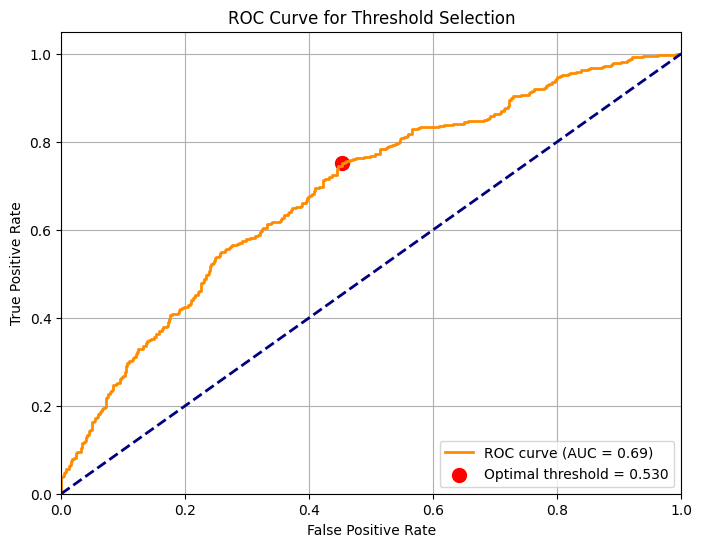

   Optimal threshold: 0.530
   AUC Score: 0.689

2. Accuracy Maximization:
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


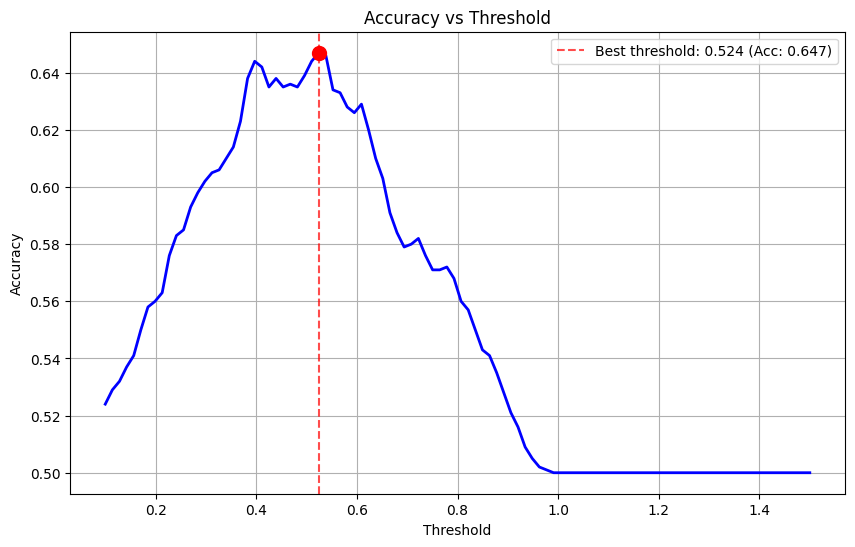

   Best threshold: 0.524
   Best accuracy: 0.647

3. Equal Error Rate:
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


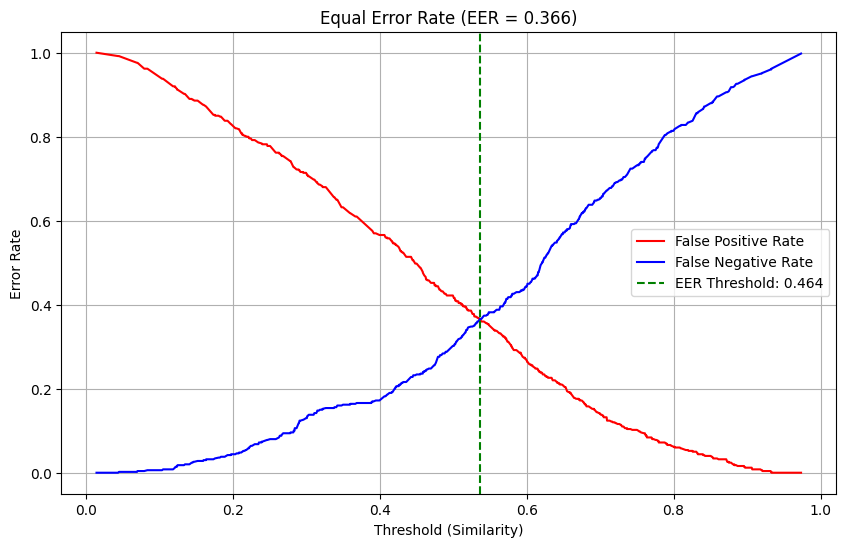

   EER threshold: 0.464
   EER rate: 0.366

4. High Precision (95%):
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Shapes: precision=(1001,), recall=(1001,), thresholds=(1000,)
Found valid threshold at index 979
Achieved precision: 0.952, recall: 0.040


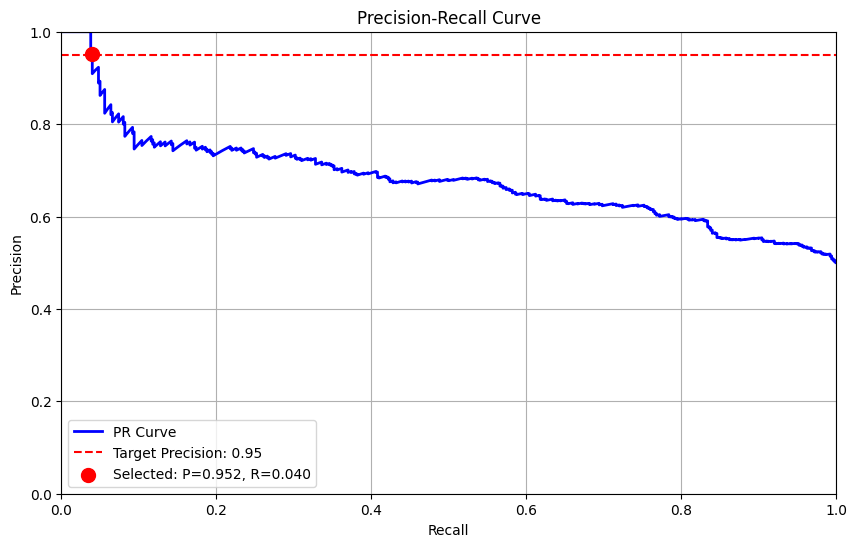

   Threshold: 0.067

=== SUMMARY ===
ROC Optimal:     0.530
Max Accuracy:    0.524
EER:             0.464
95% Precision:   0.067

RECOMMENDED: 0.530 (ROC-based)


In [28]:
def comprehensive_threshold_analysis(model, test_dataset):
    """Comprehensive analysis of different threshold selection methods"""

    print("=== COMPREHENSIVE THRESHOLD ANALYSIS ===\n")

    # Method 1: ROC-based
    print("1. ROC Curve Analysis:")
    roc_threshold, auc_score = find_optimal_threshold_roc(model, test_dataset)
    print(f"   Optimal threshold: {roc_threshold:.3f}")
    print(f"   AUC Score: {auc_score:.3f}\n")

    # Method 2: Accuracy-based
    print("2. Accuracy Maximization:")
    acc_threshold, best_acc = find_threshold_by_accuracy(model, test_dataset)
    print(f"   Best threshold: {acc_threshold:.3f}")
    print(f"   Best accuracy: {best_acc:.3f}\n")

    # Method 3: EER
    print("3. Equal Error Rate:")
    eer_threshold, eer_rate = find_eer_threshold(model, test_dataset)
    print(f"   EER threshold: {eer_threshold:.3f}")
    print(f"   EER rate: {eer_rate:.3f}\n")

    # Method 4: High precision
    print("4. High Precision (95%):")
    pr_threshold = find_threshold_precision_recall_robust(model, test_dataset, 0.95)
    print(f"   Threshold: {pr_threshold:.3f}\n")

    # Summary
    print("=== SUMMARY ===")
    print(f"ROC Optimal:     {roc_threshold:.3f}")
    print(f"Max Accuracy:    {acc_threshold:.3f}")
    print(f"EER:             {eer_threshold:.3f}")
    print(f"95% Precision:   {pr_threshold:.3f}")

    # Recommendation
    print(f"\nRECOMMENDED: {roc_threshold:.3f} (ROC-based)")

    return roc_threshold


# Run comprehensive analysis
recommended_threshold = comprehensive_threshold_analysis(
    cosine_siamese_model, test_dataset
)

In [30]:
test_predictions, test_true, test_pred = evaluate_model(
    cosine_siamese_model, test_dataset, threshold=0.53
)

32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


/Users/mario/Code/heeai/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Test Accuracy: 0.6490

Classification Report:
              precision    recall  f1-score   support

   Different       0.69      0.55      0.61       500
        Same       0.62      0.75      0.68       500

    accuracy                           0.65      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.66      0.65      0.65      1000

